In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import missingno

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from scipy import stats

In [2]:
# Reading Dataset
df = pd.read_csv('../NYC Housing Prices (Kaggle)/nyc-rolling-sales.csv')

In [3]:
# peek into dataset
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


# Defining the Variables

A reference on the trickier fields:

BOROUGH: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

BLOCK; LOT: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL.

BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE: The type of building at various points in time. See the glossary linked to below.

In [4]:
# Display variables with dtypes
df.dtypes

Unnamed: 0                         int64
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [5]:
# Drop empty column
del df['EASE-MENT']

# Drop 'Unnamed: 0' as it looks like an iterator
del df['Unnamed: 0']

# Drop Sale Date
del df['SALE DATE']

In [6]:
# Checking for duplicated entries
sum(df.duplicated(df.columns))

1358

In [7]:
# Delete the duplicates and check that it worked (df.columns drops instances of all columns being duplicates. Choosing one column would only delete if that column was duplicate)
df = df.drop_duplicates(df.columns, keep='last') # keep last because most likely last sale
sum(df.duplicated(df.columns))

0

# Data Inspection and Visualization

In [8]:
# shape of dataset
df.shape

(83190, 19)

In [9]:
# Description of every column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83190 entries, 0 to 84547
Data columns (total 19 columns):
BOROUGH                           83190 non-null int64
NEIGHBORHOOD                      83190 non-null object
BUILDING CLASS CATEGORY           83190 non-null object
TAX CLASS AT PRESENT              83190 non-null object
BLOCK                             83190 non-null int64
LOT                               83190 non-null int64
BUILDING CLASS AT PRESENT         83190 non-null object
ADDRESS                           83190 non-null object
APARTMENT NUMBER                  83190 non-null object
ZIP CODE                          83190 non-null int64
RESIDENTIAL UNITS                 83190 non-null int64
COMMERCIAL UNITS                  83190 non-null int64
TOTAL UNITS                       83190 non-null int64
LAND SQUARE FEET                  83190 non-null object
GROSS SQUARE FEET                 83190 non-null object
YEAR BUILT                        83190 non-null int64
TAX

In [10]:
# Convert some of the columns to appropriate datatype
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce') # use to_numeric when converting object to number. 'coerce' sets errors to NaN as opposed to ignoring and keeping value the same as it was.
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
# df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83190 entries, 0 to 84547
Data columns (total 19 columns):
BOROUGH                           83190 non-null category
NEIGHBORHOOD                      83190 non-null object
BUILDING CLASS CATEGORY           83190 non-null object
TAX CLASS AT PRESENT              83190 non-null category
BLOCK                             83190 non-null int64
LOT                               83190 non-null int64
BUILDING CLASS AT PRESENT         83190 non-null object
ADDRESS                           83190 non-null object
APARTMENT NUMBER                  83190 non-null object
ZIP CODE                          83190 non-null int64
RESIDENTIAL UNITS                 83190 non-null int64
COMMERCIAL UNITS                  83190 non-null int64
TOTAL UNITS                       83190 non-null int64
LAND SQUARE FEET                  57217 non-null float64
GROSS SQUARE FEET                 55913 non-null float64
YEAR BUILT                        83190 non-null in

# Missing Values

In [12]:
# checking missing values
print(df.columns[df.isnull().any()])

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')


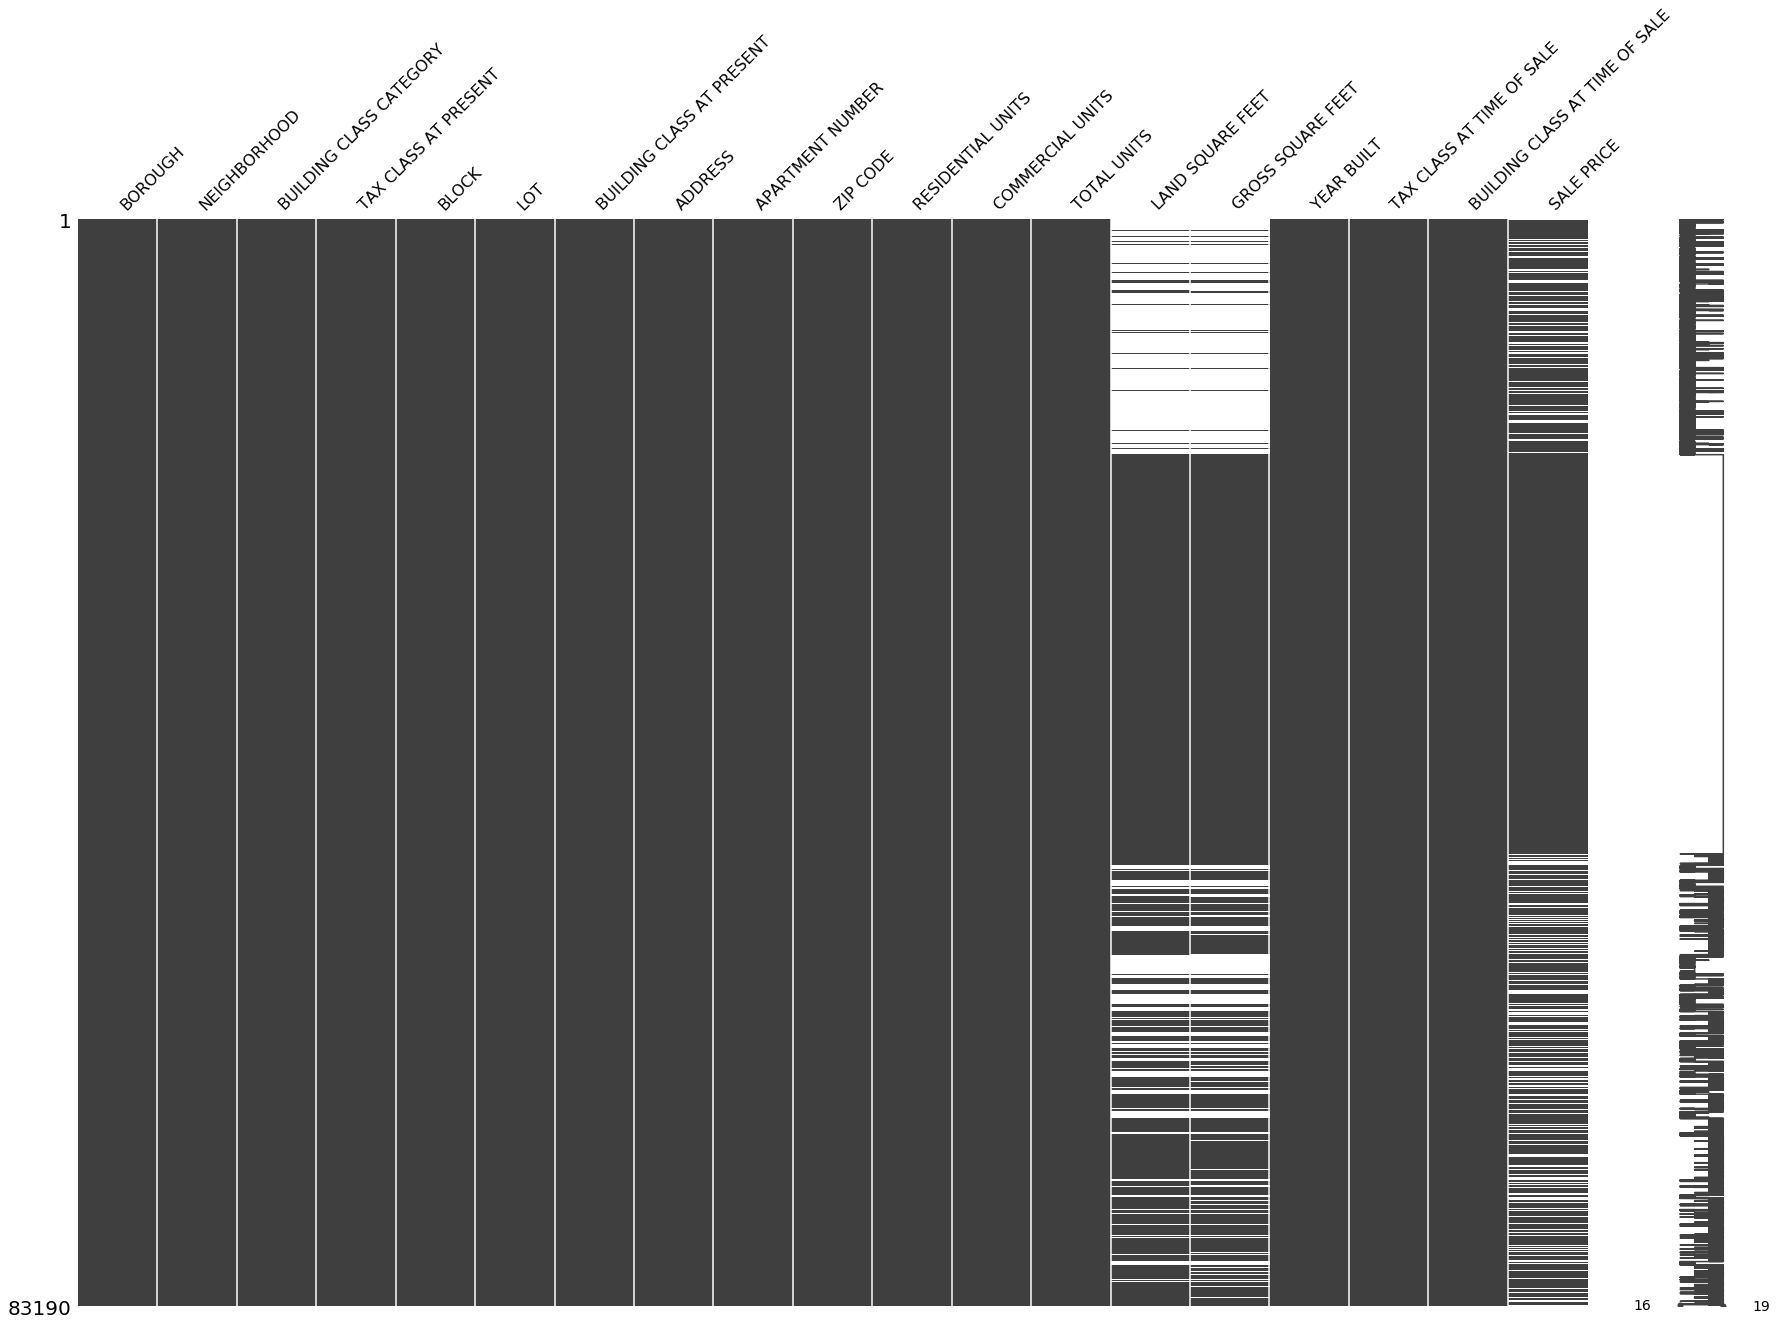

In [13]:
missingno.matrix(df, figsize = (30,20)) # 30px wide x 5px wide

In [14]:
# Function to show us how many missing values there are
def find_missing_values(df, columns):
    '''
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe (ie train)
    ::param_columns:: = list of columns (train.columns)
    '''
    missing_vals = {}
    print('Number of missing or NaN values for each column:')
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
        # missing_vals.append(str(column + ' column has {} missing or NaN values.'.format())
    return missing_vals
missing_values = find_missing_values(df, columns=df.columns)
missing_values

Number of missing or NaN values for each column:


{'BOROUGH': 0,
 'NEIGHBORHOOD': 0,
 'BUILDING CLASS CATEGORY': 0,
 'TAX CLASS AT PRESENT': 0,
 'BLOCK': 0,
 'LOT': 0,
 'BUILDING CLASS AT PRESENT': 0,
 'ADDRESS': 0,
 'APARTMENT NUMBER': 0,
 'ZIP CODE': 0,
 'RESIDENTIAL UNITS': 0,
 'COMMERCIAL UNITS': 0,
 'TOTAL UNITS': 0,
 'LAND SQUARE FEET': 25973,
 'GROSS SQUARE FEET': 27277,
 'YEAR BUILT': 0,
 'TAX CLASS AT TIME OF SALE': 0,
 'BUILDING CLASS AT TIME OF SALE': 0,
 'SALE PRICE': 13909}

In [15]:
# Find the ratio of missing values to total length of df
miss = df.isnull().sum()/len(df)
miss = miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.167196
LAND SQUARE FEET     0.312213
GROSS SQUARE FEET    0.327888
dtype: float64

In [16]:
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index
miss

,count,Name
Name,,
SALE PRICE,0.167196,SALE PRICE
LAND SQUARE FEET,0.312213,LAND SQUARE FEET
GROSS SQUARE FEET,0.327888,GROSS SQUARE FEET


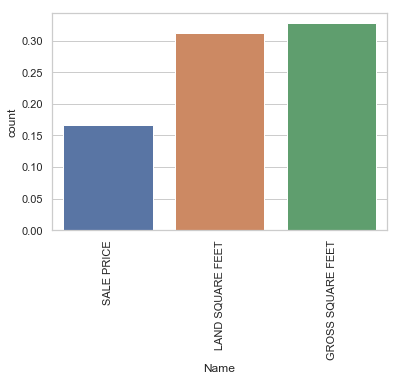

In [17]:
# plot the missing values
fig = sns.set(style='whitegrid', color_codes=True)
bar = sns.barplot(x='Name', y='count', data=miss)
plt.xticks(rotation=90)
bar

There are many missing values in the columns :

LAND SQUARE FEET

GROSS SQUARE FEET

SALE PRICE

We can drop the rows with missing values or we can fill them up with their mean, median or any other relation.

For time being, let's fill these up with mean values.

Also, we might try to predict the value of SALE PRICE as test data.

In [18]:
# For the time being, let's fill these up with mean values.
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

# Splitting Dataset

In [19]:
# Splitting dataset
test = df[df['SALE PRICE'].isna()] # dataframe of rows w/ NaN SALE PRICE
data = df[~df['SALE PRICE'].isna()] # ~ returns its complement so df of rows w/ values for SALE PRICE.

In [20]:
test = test.drop(columns = 'SALE PRICE')

In [21]:
# Print first 5 rows of test
print(test.shape)
test.head()

(13909, 18)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,516 EAST 12TH STREET,,10009,20,0,20,2581.0,9730.0,1900,2,C4
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,520 EAST 14TH STREET,,10009,44,2,46,5163.0,21007.0,1900,2,C7
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,141 AVENUE D,,10009,15,0,15,1534.0,9198.0,1920,2,D5


In [22]:
# Printing first rows of our data
print(data.shape)
data.head(10)

(69281, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633.00000,6440.000000,1900,2,C2,6625000.0
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.00000,6794.000000,1913,2,C4,3936272.0
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.00000,4615.000000,1900,2,C2,8000000.0
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,8,0,8,1750.00000,4226.000000,1920,2,C4,3192840.0
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,24,0,24,4489.00000,18523.000000,1920,2,D9,16232000.0
11,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2B,400,21,D1,530-532 EAST 5TH STREET,,10009,10,0,10,3717.00000,12350.000000,2009,2,D1,10350000.0
12,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,1.0
13,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,499000.0
14,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 3A",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,10.0
15,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3RD STREET, 5A",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,529500.0


# Check Correlations

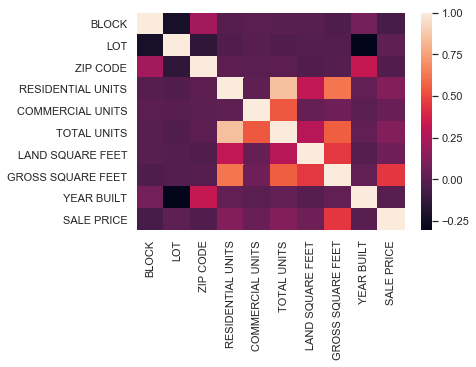

In [23]:
# correlation between the features
corr = data.corr()
sns.heatmap(corr)

Last row represents the correlation of different features with SALE PRICE

In [24]:
# numeric correlation to output variable
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.449913
TOTAL UNITS          0.126654
RESIDENTIAL UNITS    0.122566
LAND SQUARE FEET     0.060143
COMMERCIAL UNITS     0.044535
LOT                  0.012266
YEAR BUILT          -0.003779
ZIP CODE            -0.034110
BLOCK               -0.061357
Name: SALE PRICE, dtype: float64

In [25]:
numeric_data = data.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,6.928100e+04,6.928100e+04,69281.000000,6.928100e+04
mean,4200.305437,374.983473,10739.919458,1.870859,0.164244,2.055109,3.643061e+03,3.640300e+03,1800.113451,1.286521e+06
std,3434.828427,656.820333,1265.389144,14.317577,9.018311,17.026435,3.322172e+04,2.427118e+04,519.752668,1.145690e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1349.000000,21.000000,10306.000000,0.000000,0.000000,0.000000,1.900000e+03,1.268000e+03,1920.000000,2.350000e+05
50%,3377.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.970000e+03,2.400000e+03,1938.000000,5.350000e+05
75%,6192.000000,879.000000,11249.000000,2.000000,0.000000,2.000000,3.858418e+03,3.891878e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


# Target Feature: Sale Price

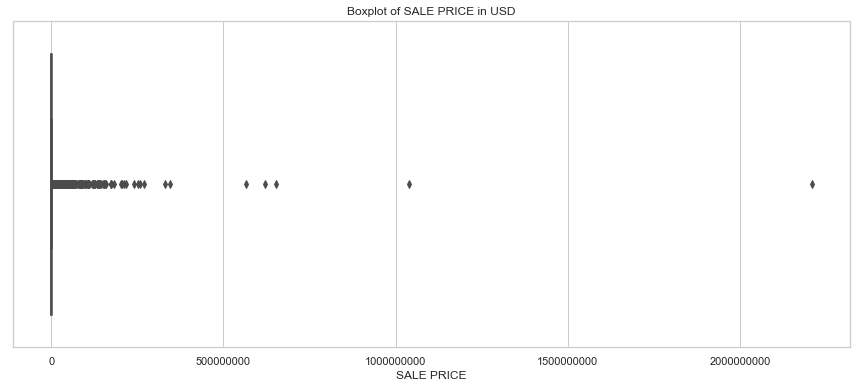

In [26]:
plt.figure(figsize=(15,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

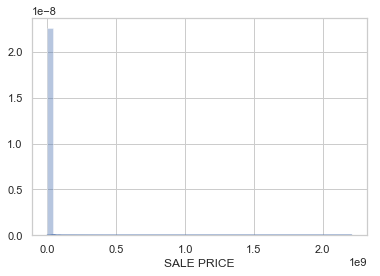

In [27]:
sns.distplot(data['SALE PRICE'])

There are many outliers in SALE PRICE. Because we know these are properties with a few sales much larger than most, remove some outliers in order to better center your data.

In addition, some 'sales' are $0 because they were inherited by family, or were mistakes in the data, so remove those as well.

In [28]:
# Remove observations that fall outside these caps:
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]

Let's check again.

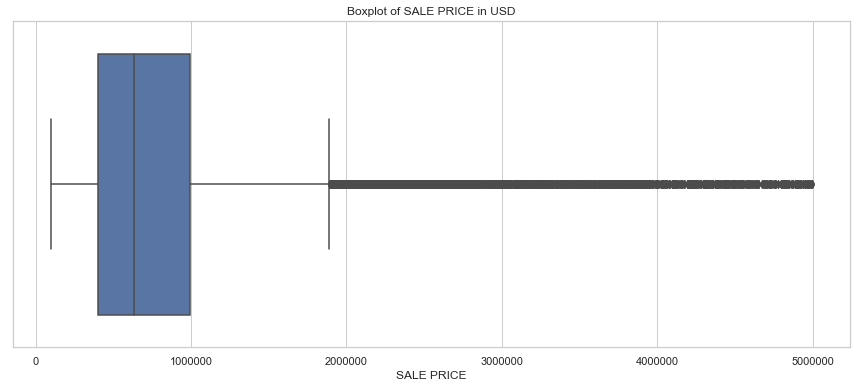

In [29]:
# Let's plot the boxplot and distplot again.

plt.figure(figsize=(15,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

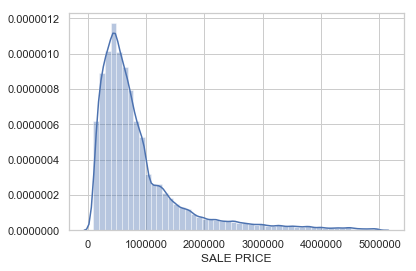

In [30]:
sns.distplot(data['SALE PRICE'])

In [31]:
# skewness of SalePrice
data['SALE PRICE'].skew()

2.3437455096169386

SALE PRICE is highly right skewed. So, we will log transform it so that it give better results.

0.19896303705046872


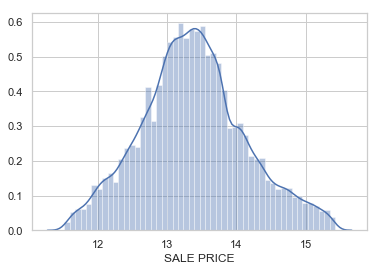

In [32]:
sales = np.log(data['SALE PRICE'])
print(sales.skew())
sns.distplot(sales)

Well now we can see the symmetry and thus it is normalized.

# Let's visualize Numerical Data

# Feature: Square Feet

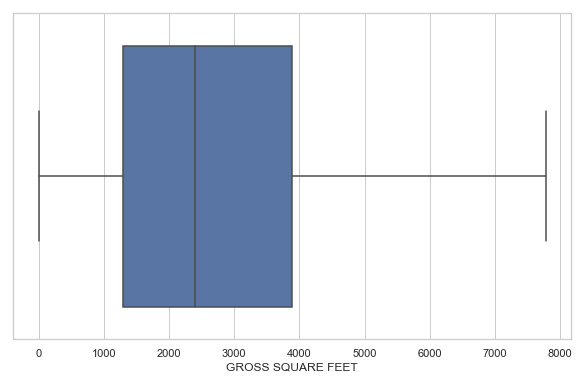

In [33]:
# boxplot for GROSS SQUARE FEET
plt.figure(figsize=(10,6))
sns.boxplot(x='GROSS SQUARE FEET', data=data, showfliers=False) # showfliers=False hides outliers

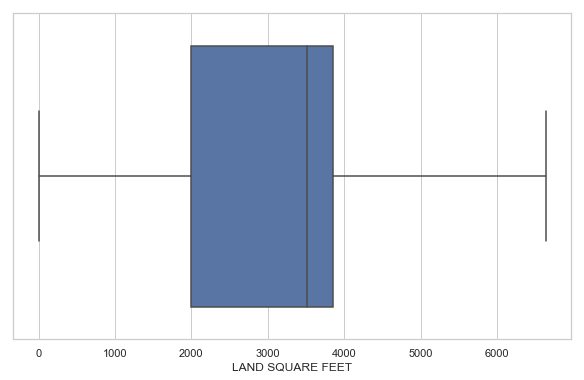

In [34]:
# boxplot for LAND SQUARE FEET
plt.figure(figsize=(10,6))
sns.boxplot(x='LAND SQUARE FEET', data=data, showfliers=False)

In [35]:
# Eliminate extreme outliers from GROSS/LAND SQUARE FEET
data = data[data['GROSS SQUARE FEET'] < 10000]
data = data[data['LAND SQUARE FEET'] < 10000]

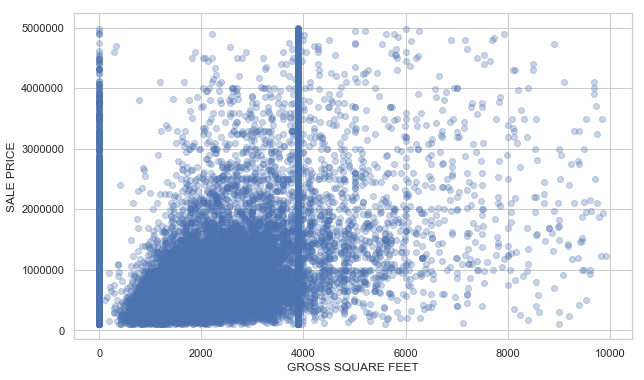

In [36]:
# Scatterplot of GROSS SQUARE FEET vs SALE PRICE
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha': 0.3})

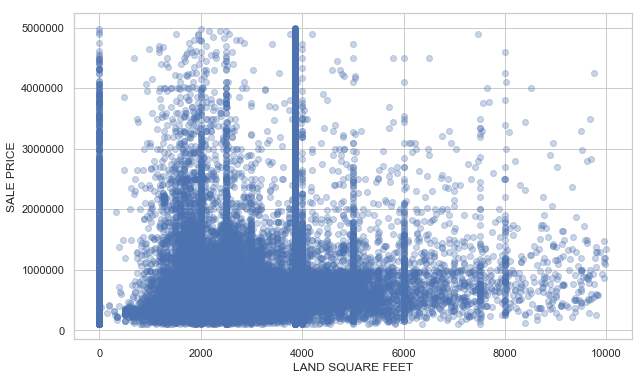

In [37]:
# Scatterplot of LAND SQUARE FEET vs SALE PRICE
plt.figure(figsize=(10,6))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha': 0.3})

In [38]:
print(data['LAND SQUARE FEET'].mean())
print(data['GROSS SQUARE FEET'].mean())

2847.0323951609803
2437.38849048009


# Feature: Total Units, Commercial Units, Residential Units

In [39]:
data[['TOTAL UNITS', 'SALE PRICE']].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,24570
0,0,15489
2,2,9473
3,3,2720
4,4,695
6,6,360
5,5,170
8,8,133
7,7,70
9,9,56


Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units

In [40]:
data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] != 2261)] 

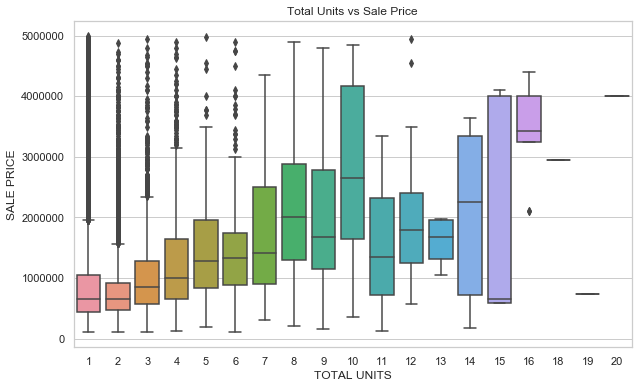

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=data)
plt.title('Total Units vs Sale Price')
plt.show()

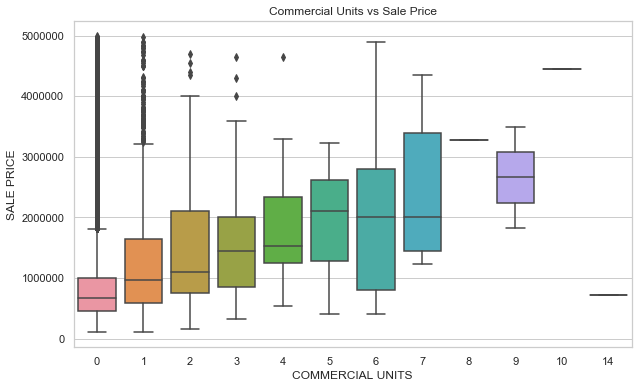

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=data)
plt.title('Commercial Units vs Sale Price')
plt.show()

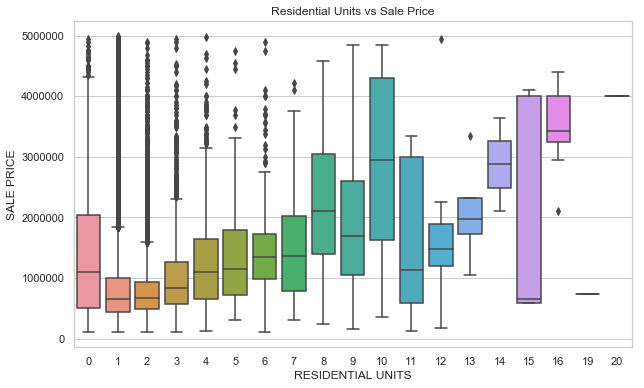

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=data)
plt.title('Residential Units vs Sale Price')
plt.show()

# Let's Visualize Categorical Data

In [44]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,38342,38342,38342,38342,38342,38342,38342,38342,38342
unique,5,247,36,9,104,30426,2642,3,104
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,R4,131-05 40TH ROAD,,1,R4
freq,12599,1674,12215,23977,8918,209,26395,25206,8922


# Feature: TAX CLASS AT PRESENT

In [45]:
# Starting with TAX CLASS AT PRESENT
data['TAX CLASS AT PRESENT'].unique()

[2B, 2, 2A, 2C, 4, 1C, 1, 1A, 1B]
Categories (9, object): [2B, 2, 2A, 2C, ..., 1C, 1, 1A, 1B]

In [46]:
pivot=data.pivot_table(index='TAX CLASS AT PRESENT', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT PRESENT,
1,594000.0
1A,390000.0
1B,640606.5
1C,958668.0
2,980000.0
2A,1200000.0
2B,1847500.0
2C,835000.0
4,1050000.0


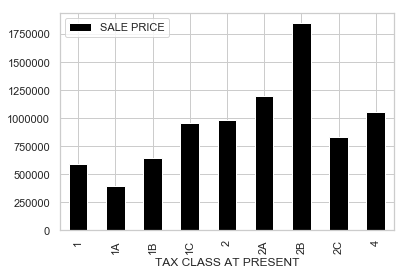

In [47]:
pivot.plot(kind='bar', color='black')

# Feature: TAX CLASS AT TIME OF SALE

In [48]:
#  TAX CLASS AT TIME OF SALE
data['TAX CLASS AT TIME OF SALE'].unique()

[2, 4, 1]
Categories (3, int64): [2, 4, 1]

In [49]:
pivot=data.pivot_table(index='TAX CLASS AT TIME OF SALE', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT TIME OF SALE,
1,582487.5
2,990000.0
4,1050000.0


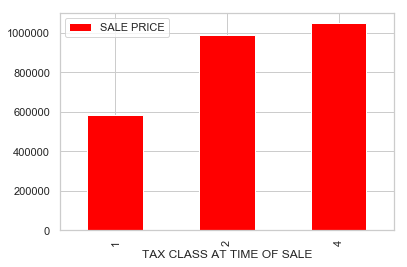

In [50]:
pivot.plot(kind='bar', color='red')

# Feature: BOROUGH

In [51]:
# BOROUGH
data['BOROUGH'].unique()

[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

In [52]:
pivot=data.pivot_table(index='BOROUGH', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
BOROUGH,
1,1435000.0
2,452750.0
3,860000.0
4,635000.0
5,470000.0


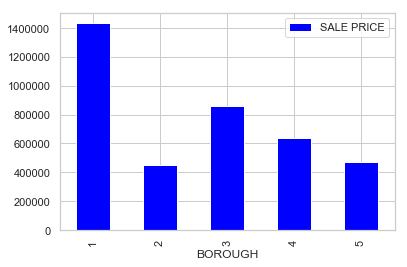

In [53]:
pivot.plot(kind='bar', color='blue')

Max SALE PRICE is Borough==1 (Manhattan) (this makes sense as Manhattan is the most expensive borough)

# Feature: BUILDING CLASS CATEGORY

In [54]:
# BUILDING CLASS CATEGORY
print(data['BUILDING CLASS CATEGORY'].nunique())

pivot=data.pivot_table(index='BUILDING CLASS CATEGORY', values='SALE PRICE', aggfunc=np.median)
pivot

36


,SALE PRICE
BUILDING CLASS CATEGORY,
01 ONE FAMILY DWELLINGS,510000.0
02 TWO FAMILY DWELLINGS,664075.5
03 THREE FAMILY DWELLINGS,820000.0
04 TAX CLASS 1 CONDOS,420405.0
05 TAX CLASS 1 VACANT LAND,720000.0
06 TAX CLASS 1 - OTHER,500000.0
07 RENTALS - WALKUP APARTMENTS,1280000.0
08 RENTALS - ELEVATOR APARTMENTS,3670000.0
11A CONDO-RENTALS,999000.0


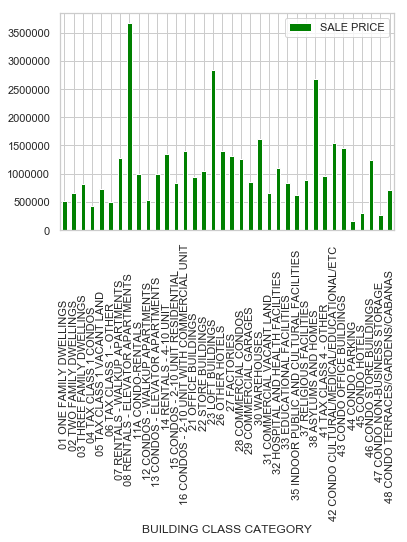

In [55]:
pivot.plot(kind='bar', color='Green')

# Data Pre Processing

Let's see our dataset again

In [56]:
del data['ADDRESS']
del data['APARTMENT NUMBER']

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 17 columns):
BOROUGH                           38342 non-null category
NEIGHBORHOOD                      38342 non-null object
BUILDING CLASS CATEGORY           38342 non-null object
TAX CLASS AT PRESENT              38342 non-null category
BLOCK                             38342 non-null int64
LOT                               38342 non-null int64
BUILDING CLASS AT PRESENT         38342 non-null object
ZIP CODE                          38342 non-null int64
RESIDENTIAL UNITS                 38342 non-null int64
COMMERCIAL UNITS                  38342 non-null int64
TOTAL UNITS                       38342 non-null int64
LAND SQUARE FEET                  38342 non-null float64
GROSS SQUARE FEET                 38342 non-null float64
YEAR BUILT                        38342 non-null int64
TAX CLASS AT TIME OF SALE         38342 non-null category
BUILDING CLASS AT TIME OF SALE    38342 non-null o

## Normalizing and Transforming Numerical columns

In [58]:
numeric_data.columns

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE'],
      dtype='object')

In [59]:
#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])

In [60]:
scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaled = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       data[col] = scaled[:,i]

In [61]:
data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.552838,-0.871424,C4,-1.442057,4.726583,-0.204406,4.897089,-0.332369,3.247655,0.176451,2,C4,2.478171
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.545023,-0.654228,C4,-1.442057,4.109626,-0.204406,4.245205,-0.669316,1.421318,0.191071,2,C4,2.174164
76,1,ALPHABET CITY,12 CONDOS - WALKUP APARTMENTS,2,-1.584890,1.174680,R2,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,-3.818937,2,R2,-0.206132
79,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.611925,1.175214,R4,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,0.191071,2,R4,0.094653
80,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.611925,1.175747,R4,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,0.191071,2,R4,0.113914


In [62]:
#Dropping few columns
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']

## One hot encoding categorical columns

In [63]:
#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']

In [64]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 56 columns):
BOROUGH_1                                                               38342 non-null uint8
BOROUGH_2                                                               38342 non-null uint8
BOROUGH_3                                                               38342 non-null uint8
BOROUGH_4                                                               38342 non-null uint8
BOROUGH_5                                                               38342 non-null uint8
BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                         38342 non-null uint8
BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                         38342 non-null uint8
BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                       38342 non-null uint8
BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS                           38342 non-null uint8
BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND    

In [65]:
# Replacing categorical columns with dummies
fdf = data.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)

In [66]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 66 columns):
BLOCK                                                                   38342 non-null float64
LOT                                                                     38342 non-null float64
ZIP CODE                                                                38342 non-null float64
RESIDENTIAL UNITS                                                       38342 non-null float64
COMMERCIAL UNITS                                                        38342 non-null float64
TOTAL UNITS                                                             38342 non-null float64
LAND SQUARE FEET                                                        38342 non-null float64
GROSS SQUARE FEET                                                       38342 non-null float64
YEAR BUILT                                                              38342 non-null float64
SALE PRICE                          

# Train/Test Split

In [67]:
Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape

((38342, 65), (38342,))

In [68]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.3 , random_state =34)

In [69]:
#Testing set
X_test.shape , Y_test.shape

((11503, 65), (11503,))

# Modelling

In [70]:
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

## Linear Regression

In [71]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test,Y_pred_lin)

0.7535412926078288

## Lasso Regression

In [72]:
alpha=0.00099
lasso_regr=Lasso(alpha=alpha,max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso=lasso_regr.predict(X_test)
rmse(Y_test,Y_pred_lasso)

0.7545342173339241

## Ridge Regression

In [73]:
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
rmse(Y_test,Y_pred_ridge)

0.753632824540732

## RandomForest Regressor

In [74]:
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test,Y_pred_rf)

0.5810668075428223

# Conclusion

The dataset works best with the Random Forest Regressor, with RSME score of 0.588.